# Sequential Auction (SA) models

In [ ]:
!pip install rsome
!pip install mosek
!rm mosek.lic
!git clone https://github.com/erickdelage/80624
!cp ./80624/mosek.lic .
!rm -r ./80624
!mkdir -p /root/mosek
!cp ./mosek.lic /root/mosek
!pip install -i https://pypi.gurobi.com gurobipy

Cloning into '80624'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.
Looking in indexes: https://pypi.gurobi.com


In [ ]:
import rsome as rso
import numpy as np
from rsome import ro
from rsome import msk_solver as my_solver  #Import Mosek solver interface
#from rsome import grb_solver as my_solver  #Import Gurobi solver interface

## Data (10 cars, 5 aution sequences)

In [ ]:
# Number of cars
ncar = 10

# Number of sequences
nseq = 5

# Estimated values by seller
v = np.array([20, 21, 24, 22.5, 28, 20.6, 23.4, 25.4, 18.4, 14])

# Initial prices (new)
a = np.array([30, 35, 36, 33, 37, 28, 30, 32, 25, 22])

# Storage price
c = np.array([0.1, 0.3, 0.3, 0.2, 0.4, 0.3, 0.2, 0.3, 0.4, 0.1])

# Nominal prices
p = np.array(
    [[20.5, 23.1, 23.6, 22.8, 21.5],
     [20.4, 22.5, 25.5, 22.6, 24.4],
     [27.6, 26.1, 26.9, 33.7, 30.8],
     [22.3, 24.5, 24.7, 23.5, 22.5],
     [28.5, 33.4, 29.5, 27.1, 28.5],
     [26.9, 25.8, 26.3, 23.6, 27.3],
     [29.9, 27.5, 19.2, 28.7, 27.9],
     [29.2, 30.9, 27.3, 28.2, 29.5],
     [20.8, 24.0, 23.7, 24.6, 22.1],
     [19.2, 18.7, 19.3, 20.1, 19.2]
     ]
)

# Price Variance
p_var = np.array(
    [[0.0571, -0.6687, 0.2040, -0.4741, 0.3082],
     [0.3784, 0.4963, -0.0989, -0.8324, -0.542],
     [0.8267, -0.6952, 0.6516, 0.0767, 0.9923],
     [-0.8436, -0.1146, -0.7867, 0.9238, -0.9907],
     [0.5498, 0.6346, 0.7374, -0.8311, -0.2004],
     [-0.4803, 0.6001, -0.1372, 0.8213, -0.6363],
     [-0.4724, -0.7089, -0.7279, 0.7386, 0.1594],
     [0.0997, -0.7101, 0.7061, 0.2441, -0.2981],
     [0.0265, -0.1964, -0.8481, -0.5202, -0.7534],
     [-0.6322, -0.5201, 0.1655, -0.9007, 0.8054]])

# **Sequential auction nominal model (SAN-Model)**


 \begin{align}
 \max_x & \sum_{i=1}^n\sum_{t=1}^m(P_{it}-v_i)x_{it}-\sum_{i=1}^n(c_i(1-\sum_{t=1}^mx_{it}))&\\
\text{s.t.} &\sum_{t=1}^mP_{it}x_{it} \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}


In [ ]:
model_SAN = ro.Model('SAN')

# Define decision variables
x_SAN = model_SAN.dvar((ncar, nseq), vtype='B')

# objective function
model_SAN.max(
    ((p * x_SAN).sum() - (v @ x_SAN).sum()) - ((np.ones(ncar) - x_SAN.sum(axis=1)) @ c)
)

# constraints
model_SAN.st((p * x_SAN).sum(axis=1) <= a)
model_SAN.st(x_SAN.sum(axis=0) >= 1)
model_SAN.st(x_SAN.sum(axis=1) <= 1)

# solve model
model_SAN.solve(my_solver)

print(model_SAN.get())
print('')
print(x_SAN.get())

Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0173s
56.400000000000006

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


# **Sequential auction robust model**
 \begin{align}
 \max_{x,w} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}  S + \sum_{i=1}^n\sum_{t=1}^m(\tilde{p}_{it}\xi_{it})x_{it} \ge w & \\
&\sum_{t=1}^m(p_{it}+\tilde{p}_{it}\xi_{it})x_{it} \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

 where 
 \begin{align}S=\sum_{i=1}^n\sum_{t=1}^m(p_{it}-v_i)x_{it}-\sum_{i=1}^n(c_i(1-\sum_{t=1}^mx_{it}))\end{align}

# Box Uncertainty model

\begin{align}
Z^{Box}=\{\xi \in U : || {\xi}||_\infty  \le \Theta\}=\{\xi : |\xi|\le \Theta\}
\end{align}

Model given in the paper:

\begin{align}
 \max_{x,w} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}  S \ge w & \\
&\sum_{t=1}^mp_{it}x_{it}+\Theta \sum_{t=1}^m \tilde{p}_{it}x_{it} \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

In [ ]:
# Model as presented in the paper
def boxset_p(Theta):
    model_Box = ro.Model('Box_paper')

    # Define decision variables
    x_box = model_Box.dvar((ncar, nseq), vtype='B')
    s_box = model_Box.dvar(1)

    # objective function
    model_Box.max(s_box)

    # constraints
    model_Box.st(s_box <= ((p * x_box).sum() - (v @ x_box).sum()) - ((np.ones(ncar) - x_box.sum(axis=1)) @ c))
    model_Box.st((p * x_box).sum(axis=1) + Theta*(p_var * x_box).sum(axis=1) <= a)
    model_Box.st(x_box.sum(axis=0) >= 1)
    model_Box.st(x_box.sum(axis=1) >= 0)
    model_Box.st(x_box.sum(axis=1) <= 1)

    # solve model
    model_Box.solve(my_solver)

    return model_Box.get(), x_box.get()

Our reformulation
\begin{align}
 \max_{x,w,\lambda^+,\lambda^-,\gamma^+,\gamma^-} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}   \Theta\sum_{i=1}^n\sum_{t=1}^m (\lambda_{it}^++\lambda_{it}^-)\ge w -S & \\
& \lambda_{it}^+-\lambda_{it}^-= \tilde{p}_{it}x_{it} &  \forall i, \forall t\\
&\Theta\sum_{t=1}^m(\gamma_{it}^++\gamma_{it}^-) \le a_i-\sum_{t=1}^mp_{it}x_{it}, & \forall i\\
&\gamma_{it}^+-\gamma_{it}^- =   \tilde{p}_{it}x_{it} & \forall i, \forall t\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& \lambda_{it}^+,\lambda_{it}^- \le 0 & \forall i, \forall t\\
& \gamma_{it}^+,\gamma_{it}^- \ge 0 & \forall i, \forall t\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

In [ ]:
def boxset(Theta):

    model_Box2 = ro.Model('Box')

    # Define decision variables
    x_box2 = model_Box2.dvar((ncar, nseq), vtype='B')
    s_box2 = model_Box2.dvar(1)
    l1_box2 = model_Box2.dvar(nseq)
    g1_box2 = model_Box2.dvar(nseq)
    l2_box2 = model_Box2.dvar((ncar, nseq))
    g2_box2 = model_Box2.dvar((ncar, nseq))

    # objective function
    model_Box2.max(s_box2)

    # constraints
    model_Box2.st(
      Theta*(l1_box2 + g1_box2).sum() >= s_box2 - ((p * x_box2).sum() - (v @ x_box2).sum()) + ((np.ones(ncar) - x_box2.sum(axis=1)) @ c)
    )
    model_Box2.st(l1_box2 - g1_box2 == (p_var * x_box2).sum(axis=0))
    for i in range(ncar):
      model_Box2.st(
          Theta*(l2_box2[i] + g2_box2[i]).sum() <= a[i] - (p * x_box2).sum(axis=1)[i]
      )
      model_Box2.st(l2_box2[i] - g2_box2[i] == (p_var * x_box2)[i])
    model_Box2.st(x_box2.sum(axis=0) >= 1)
    model_Box2.st(x_box2.sum(axis=1) >= 0)
    model_Box2.st(x_box2.sum(axis=1) <= 1)
    model_Box2.st(l1_box2 <= 0)
    model_Box2.st(g1_box2 <= 0)
    model_Box2.st(l2_box2 >= 0)
    model_Box2.st(g2_box2 >= 0)

    # solve model
    model_Box2.solve(my_solver)

    return model_Box2.get(), x_box2.get()

# Ellipsoidal Set



\begin{align}
Z^{Ellipsoid}=\{\xi \in U : || {\xi}||_2  \le \Omega\}=\{\xi : \sqrt{\sum_{t} \xi_{it}^{2}} \le \Theta\}
\end{align}

Model given in the paper:

\begin{align}
 \max_{x,w} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}  S \ge w & \\
&\sum_{t=1}^mp_{it}x_{it}+\Omega \sqrt{ (\sum_{t=1}^m \tilde{p}_{it}x_{it})^{2} } \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

In [ ]:
# Model as presented in the paper
def ellset_p(Omega):
    model = ro.Model('Ellipsoidal_paper')

    # Define decision variables
    x = model.dvar((ncar, nseq), vtype='B')
    s = model.dvar(1)

    # objective function
    model.max(s)

    # constraints
    model.st(s <= ((p * x).sum() - (v @ x).sum()) - ((np.ones(ncar) - x.sum(axis=1)) @ c))
    for i in range(ncar):
      model.st(
          (p * x).sum(axis=1)[i] + Omega * ro.norm((p_var * x)[i], 2) <= a[i]
          # (p * x).sum(axis=1)[i] + Omega * ro.norm((p_var * x).sum(axis=1)[i], 2) <= a[i]
      )
    model.st(x.sum(axis=0) >= 1)
    model.st(x.sum(axis=1) >= 0)
    model.st(x.sum(axis=1) <= 1)

    # solve model
    model.solve(my_solver)

    return model.get(), x.get()

Our reformulation:
\begin{align}
 \max_{x,w} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}  \Omega \sqrt{ (\sum_{i=1}^{n} \sum_{t=1}^{m} \tilde{p}_{it} x_{it})^{2} } \ge w - S & \\
&\sum_{t=1}^mp_{it}x_{it}+ \Omega \sqrt{(\sum_{t=1}^m \tilde{p}_{it}x_{it})^{2} } \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

In [ ]:
def ellset(Omega):
    model = ro.Model('Ellipsoidal')

    # Define decision variables
    x = model.dvar((ncar, nseq), vtype='B')
    s = model.dvar(1)

    # objective function
    model.max(s)

    # constraints
    model.st(
        -Omega*ro.norm((p_var*x).sum(axis=1), 2) >= s - ((p * x).sum() - (v @ x).sum()) + ((np.ones(ncar) - x.sum(axis=1)) @ c)
        )
    for i in range(ncar):
      model.st(
          (p * x).sum(axis=1)[i] + Omega * ro.norm((p_var * x)[i], 2) <= a[i]
      )
    model.st(x.sum(axis=0) >= 1)
    model.st(x.sum(axis=1) >= 0)
    model.st(x.sum(axis=1) <= 1)

    # solve model
    model.solve(my_solver)

    return model.get(), x.get()

# Polyhedron Set

\begin{align}
Z^{Polyhedron}=\{\xi \in U : || {\xi}||_1  \le \Gamma_i\}=\{\xi : \sum_{t} |\xi_{it}| \le \Gamma_i\}
\end{align}

Model given in the paper:

\begin{align}
 \max_{x,w} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}  S - \sum_{i=1}^{n} \Gamma_i \tilde{p}_{it} x_{it} \ge w & \\
&\sum_{t=1}^mp_{it}x_{it}+\Gamma_i \tilde{p}_{it} x_{it} \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

In [ ]:
# Model as presented in the paper
def poly_p(Gamma):
    model = ro.Model('Poyhedron_paper')

    # Define decision variables
    x = model.dvar((ncar, nseq), vtype='B')
    s = model.dvar(1)

    print((p_var * x).sum().shape)

    # objective function
    model.max(s)

    # constraints
    for t in range(nseq):
        model.st(
            (((p * x).sum() - (v @ x).sum()) - ((np.ones(ncar) - x.sum(axis=1)) @ c)) - Gamma*((p_var * x).T[t]).sum() >= s
            )
    model.st((p * x).sum(axis=1) + Gamma*(p_var * x).sum(axis=1) <= a)
    model.st(x.sum(axis=0) >= 1)
    model.st(x.sum(axis=1) >= 0)
    model.st(x.sum(axis=1) <= 1)

    # solve model
    model.solve(my_solver)

    return model.get(), x.get()

Our reformulation:
\begin{align}
 \max_{x,w,\Lambda, \gamma, \lambda^+,\lambda^-,\pi^+,\pi^-} \hspace{5mm} & w &\\
                \text{s.t.} \hspace{5mm} & \Gamma\gamma\le S-w &\\
            & -\gamma_i+\lambda_{it}^+= \tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                &-\gamma_i+\lambda_{it}^-= -\tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                &\Gamma_i\Lambda_i\leq a_{i} - \sum_{t=1}^{m} p_{it} x_{it} & \forall i \in I\\
            & \Lambda_i-\pi_{it}^+= \tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                &\Lambda_i-\pi_{it}^-= -\tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                & \sum_{i=1}^n x_{it} \ge 1 & \forall t \in T\\
                & 0 \le \sum_{t=1}^m x_{it} \le 1 & \forall i \in I\\
                 & x_{it} \in \{0,1\} & \forall i \in I, \forall t \in T \\
                & \lambda_{it}^{+}, \lambda_{it}^{-}, \pi_{it}^{+}, \pi_{it}^{-} \geq 0 & \forall i \in I, \forall t \in T \\
                &\gamma_i, \Lambda_i \ge 0 &\forall i \in I
 \end{align}

In [ ]:
def poly(Gamma):
    model = ro.Model('Poyhedron')

    # Define decision variables
    x = model.dvar((ncar, nseq), vtype='B')
    s = model.dvar(1)
    lambda_plus = model.dvar((ncar, nseq))
    lambda_minus = model.dvar((ncar, nseq))
    gamma = model.dvar(ncar)
    Delta = model.dvar(ncar)
    pi_plus = model.dvar((ncar, nseq))
    pi_minus = model.dvar((ncar, nseq))

    # objective function
    model.max(s)

    # constraints
    model.st(((Gamma*np.ones(ncar)) * gamma).sum() <= (((p * x).sum() - (v @ x).sum()) - ((np.ones(ncar) - x.sum(axis=1)) @ c)) - s)
    for i in range(ncar):
      for t in range(nseq):
        model.st(-gamma[i] + lambda_plus[i,t] == (p_var[i,t] * x[i,t]))
        model.st(-gamma[i] + lambda_minus[i,t] == -(p_var[i,t] * x[i,t]))

    
    model.st((Gamma*np.ones(ncar)) * Delta <= a - (p * x).sum(axis=1))

    for i in range(ncar):
      for t in range(nseq):
        model.st(-pi_plus[i,t] + Delta[i] == (p_var[i,t] * x[i,t]))
        model.st(-pi_minus[i,t] + Delta[i] == -(p_var[i,t] * x[i,t]))

    model.st(x.sum(axis=0) >= 1)
    model.st(x.sum(axis=1) >= 0)
    model.st(x.sum(axis=1) <= 1)
    model.st(lambda_plus >= 0)
    model.st(lambda_minus >= 0)
    model.st(Delta >= 0)
    model.st(pi_plus >= 0)
    model.st(pi_minus >= 0)

    # solve model
    model.solve(my_solver)

    return model.get(), x.get()

# Box-Polyhedron Set

\begin{align}
Z^{Box-Polyhedron}=\{\xi \in U : || {\xi}||_\infty  \le \Theta, || {\xi}||_\infty \leq \Gamma\}=\{\xi : |\xi_{it}| \leq \Theta, \sum_{t} |\xi_{it}| \le \Gamma_i\}
\end{align}

Model given in the paper:

\begin{align}
 \max_{x,w, \mathcal{z}, q} & \hspace{0.5cm} w &\\
\text{s.t.} &  \hspace{0.2cm}  S - \sum_{i=1}^{n} \Gamma \mathcal{z}_{i} \ge w & \\
& \mathcal{z}_{i} + q_{it} \geq \tilde{p}_{it} x_{it} & \forall i, \forall t \\
&\sum_{t=1}^mp_{it}x_{it}+ \Gamma \mathcal{z}_{i} + \Theta \sum_{t=1}^{m} q_{it} \le a_i, & \forall i\\
& x_{it} \in \{0,1\}, & \forall i, \forall t \\
& \sum_{i=1}^n x_{it} \ge 1, & \forall t\\
& 0 \le \sum_{t=1}^m x_{it} \le 1, & \forall i\\
& \mathcal{z}, q \geq 0 & \\
& i=1,2,...,n&\\
& t=1,2,...,m&
 \end{align}

In [ ]:
# Model as presented in the paper
def box_poly_p(Theta, Gamma):
    model = ro.Model('Box_Poyhedron_paper')

    # Define decision variables
    x = model.dvar((ncar, nseq), vtype='B')
    s = model.dvar(1)
    z = model.dvar(ncar)
    q = model.dvar((ncar, nseq))

    # objective function
    model.max(s)

    # constraints
    model.st( (((p * x).sum() - (v @ x).sum()) - ((np.ones(ncar) - x.sum(axis=1)) @ c)) - Gamma*z.sum() >= s )
    model.st((p * x).sum(axis=1) + (Gamma * z) + (Theta * q.sum(axis=1)) <= a)
    # for t in range(nseq):
      # model.st(z + q.T[t].T >= (p_var * x).T[t].T)
    model.st(z + q.sum(axis=1) >= (p_var * x).sum(axis=1))
    model.st(x.sum(axis=0) >= 1)
    model.st(x.sum(axis=1) >= 0)
    model.st(x.sum(axis=1) <= 1)
    model.st(z >= 0)
    model.st(q >= 0)

    # solve model
    model.solve(my_solver)

    return model.get(), x.get()

Our reformulation:
\begin{align}
 \max_{\substack{x,w, \gamma, \Lambda, \lambda^{+},\lambda^{-},\\\mu^+,\mu^-,\pi^{+},\pi^{-},\eta^+,\eta^-}} \hspace{5mm} & w &\\
                \text{s.t.} \hspace{5mm}  &\sum_{i=1}^n \Gamma_i\gamma_i + \theta \sum_{i=1}^n \sum_{t=1}^m (\mu_{it}^+ + \mu_{it}^-) \le S-w\\
            & -\gamma_i-\mu_{it}^++\mu_{it}^-+\lambda_{it}^+= \tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                &-\gamma_i+\mu_{it}^+-\mu_{it}^-+\lambda_{it}^-= -\tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                & \Gamma_i\Lambda_i +\theta  \sum_{t=1}^m (\eta_{it}^+ + \eta_{it}^-)\leq a_{i} - \sum_{t=1}^{m} p_{it} x_{it} & \forall i \in I\\
             & \Lambda_i+\eta_{it}^+-\eta_{it}^--\pi_{it}^+= \tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
             &\Lambda_i-\eta_{it}^++\eta_{it}^--\pi_{it}^-= -\tilde{p}_{it}x_{it} & \forall i \in I, \forall t \in T \\
                & \sum_{i=1}^n x_{it} \ge 1 & \forall t \in T\\
                & 0 \le \sum_{t=1}^m x_{it} \le 1 & \forall i \in I\\
                 & x_{it} \in \{0,1\} & \forall i \in I, \forall t \in T \\
                 & \lambda_{it}^{+}, \lambda_{it}^{-},  \mu_{it}^+,\mu_{it}^-, \pi_{it}^{+}, \pi_{it}^{-},  \eta_{it}^+,\eta_{it}^- \geq 0 & \forall i \in I, \forall t \in T \\
                &\gamma_i, \Lambda_i \ge 0 &\forall i \in I
 \end{align}

In [ ]:
def box_poly(Theta, Gamma):
    model = ro.Model('Box_Poyhedron')

    # Define decision variables
    x = model.dvar((ncar, nseq), vtype='B')
    s = model.dvar(1)
    lambda_plus = model.dvar((ncar, nseq))
    lambda_minus = model.dvar((ncar, nseq))
    gamma = model.dvar(ncar)
    Delta = model.dvar(ncar)
    pi_plus = model.dvar((ncar, nseq))
    pi_minus = model.dvar((ncar, nseq))
    mu_plus = model.dvar((ncar, nseq))
    mu_minus = model.dvar((ncar, nseq))
    eta_plus = model.dvar((ncar, nseq))
    eta_minus = model.dvar((ncar, nseq))


    # objective function
    model.max(s)

    # constraints
    model.st(((Gamma*np.ones(ncar)) * gamma).sum() + Theta*(mu_plus + mu_minus).sum() <= (((p * x).sum() - (v @ x).sum()) - ((np.ones(ncar) - x.sum(axis=1)) @ c)) - s)
    for i in range(ncar):
      for t in range(nseq):
        model.st(-gamma[i] - mu_plus[i,t] + mu_minus[i,t] + lambda_plus[i,t] == (p_var[i,t] * x[i,t]))
        model.st(-gamma[i] + mu_plus[i,t] - mu_minus[i,t] + lambda_minus[i,t] == -(p_var[i,t] * x[i,t]))

    
    model.st((Gamma*np.ones(ncar)) * Delta + Theta*(eta_plus + eta_minus).sum(axis=1) <= a - (p * x).sum(axis=1))

    for i in range(ncar):
      for t in range(nseq):
        model.st(-pi_plus[i,t] + Delta[i] + eta_plus[i,t] - eta_minus[i,t] == (p_var[i,t] * x[i,t]))
        model.st(-pi_minus[i,t] + Delta[i] - eta_plus[i,t] + eta_minus[i,t] == -(p_var[i,t] * x[i,t]))



    model.st(x.sum(axis=0) >= 1)
    model.st(x.sum(axis=1) >= 0)
    model.st(x.sum(axis=1) <= 1)
    model.st(lambda_plus >= 0)
    model.st(lambda_minus >= 0)
    model.st(Delta >= 0)
    model.st(pi_plus >= 0)
    model.st(pi_minus >= 0)
    model.st(mu_plus >= 0)
    model.st(mu_minus >= 0)
    model.st(eta_plus >= 0)
    model.st(eta_minus >= 0)

    # solve model
    model.solve(my_solver)

    return model.get(), x.get()

# Results

Comparing formulations as presented in the paper vs. our reformulations

In [ ]:
set_params = 11

# Box Set
res_box = [0]*set_params

for i in range(set_params):
    temp_obj, _ = boxset(i)
    res_box[i] = temp_obj

# Ellipsoid Set
res_ell = [0]*set_params

for i in range(set_params):
    temp_obj, _ = ellset(i)
    res_ell[i] = temp_obj


# Polyhedron Set
res_poly = [0]*set_params

for i in range(set_params):
    temp_obj, _ = poly(i)
    res_poly[i] = temp_obj


# Box-Polyhedron Set
res_box_poly = [0]*set_params

for i in range(set_params):
    temp_obj, _ = box_poly(i, i)
    res_box_poly[i] = temp_obj

Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0132s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0423s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0253s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0216s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0223s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0208s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0221s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0207s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0202s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0224s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0216s
Being solved by Mosek...
Solution status: integer_optimal
Running time: 0.0125s
Being solved by Mosek...
Solution status

In [ ]:
# Their results 
res_p_box = [56.4, 56.4, 56.4, 56.4, 56.4, 56.4, 52.5, 52.5, 52.5, 52.5, 52.5]
res_p_ell = [56.4, 53.7, 52, 50.5, 50.5, 50.3, 43.3, 43.3, 43.3, 43, 43]
res_p_poly = [56.4, 55.4847, 54.5694, 53.7661, 53.0548, 52.3435, 50.5398, 50.4631, 50.3864, 50.3097, 50.2330]
res_p_box_poly = [56.4, 51.4195, 46.5390, 41.8585, 30.4780, 27.8975, 23.1170, 15.6365, 11.3560, 2.8755, 0.2950]

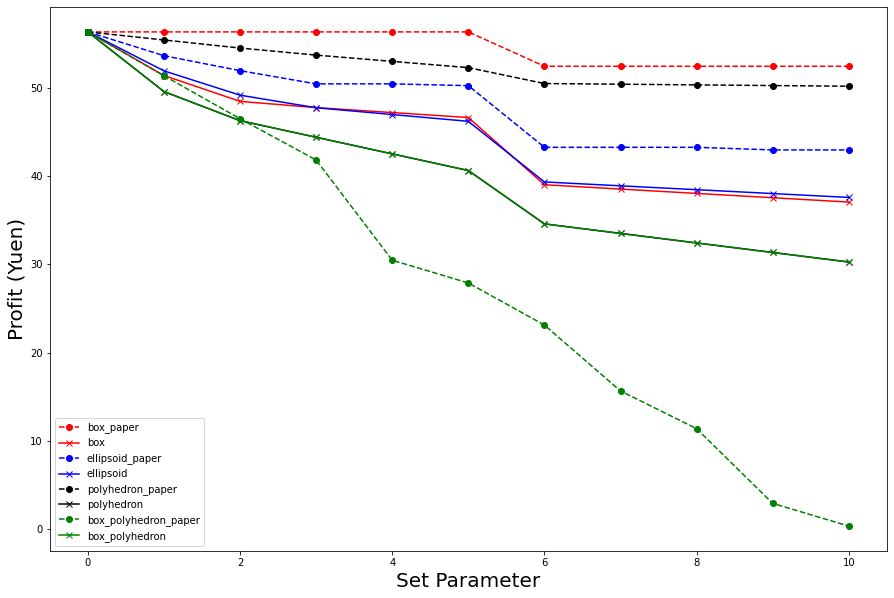

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))
plt.plot(np.arange(set_params), res_p_box, '--ro', label='box_paper')
plt.plot(np.arange(set_params), res_box, '-rx', label='box')
# plt.plot(np.arange(set_params), res_box_rsome, '-ro', label='box_rsome')
plt.plot(np.arange(set_params), res_p_ell, '--bo', label='ellipsoid_paper')
plt.plot(np.arange(set_params), res_ell, '-bx', label='ellipsoid')
plt.plot(np.arange(set_params), res_p_poly, '--ko', label='polyhedron_paper')
plt.plot(np.arange(set_params), res_poly, '-kx', label='polyhedron')
plt.plot(np.arange(set_params), res_p_box_poly, '--go', label='box_polyhedron_paper')
plt.plot(np.arange(set_params), res_box_poly, '-gx', label='box_polyhedron')
plt.xlabel('Set Parameter', fontsize=20)
plt.ylabel('Profit (Yuen)', fontsize=20)
plt.legend()
plt.savefig('SAN_results.pdf')
plt.show()
plt.close()